In [1]:
import cv2
import time
import mmcv
import glob
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
from IPython import display
from PIL import Image, ImageDraw
from torchvision import transforms, datasets
from facenet_pytorch import MTCNN, InceptionResnetV1, extract_face


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [3]:
model_gend = models.wide_resnet50_2(pretrained=False)
num_features = model_gend.fc.in_features
model_gend.fc = torch.nn.Linear(num_features, 2)
model_gend.load_state_dict(torch.load('models/model_gend'))
model_gend.eval()
model_gend.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [4]:
model_em = models.wide_resnet50_2(pretrained=False)
num_features = model_em.fc.in_features
model_em.conv1 = torch.nn.Conv2d(1,64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model_em.fc = torch.nn.Linear(num_features, 3)
model_em.load_state_dict(torch.load('models/model_emotion.pth'))
model_em.eval()
model_em.to(device)


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [5]:
model_age = models.wide_resnet50_2(pretrained=False)
num_features = model_age.fc.in_features
model_age.fc = torch.nn.Linear(num_features, 5)
model_age.load_state_dict(torch.load('models/model_age2.pth'))
model_age.eval()
model_age.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [6]:
mtcnn = MTCNN(keep_all=True, device=device)

In [43]:
r = np.random.randint(low=0, high=1387)
#path = 'im_val/'
path = 'wider/WIDER_train/WIDER_train/images/16--Award_Ceremony'
text_files = glob.glob(path + "/*.jpg", recursive = True)

In [44]:
# Mujer:1, Hombre:0
gen_dict = {0:'Hombre', 1:'Mujer'}
em_dict = {0:'Angry',1:'Neutral',2:'Happy'}
age_dict = {0:'0-15 años', 1:'16-30 años', 2:'31-45 años', 3:'46-60 años', 4:'Más de 60 años'}

In [49]:
start_time = time.time()

#img = Image.open(path+str(r)+'.jpg')
r = np.random.randint(low=0, high=len(text_files))
img = Image.open(text_files[r])

boxes, probs = mtcnn.detect(img)
faces = []
if boxes is not None:
    for i, (box, prob) in enumerate(zip(boxes, probs)):
        if prob>.85:
            face = extract_face(img, box, save_path="all/detected_face_{}.png".format(i))
            faces.append(face)

t = torch.stack(faces)/255

outputs = model_gend(t.to(device))
_, preds_gend = torch.max(outputs, 1)

outputs = model_age(t.to(device))
_, preds_age = torch.max(outputs, 1)

emotion = []

if t.shape[0]>1:
    for ts in t:
        t = transforms.ToPILImage()(ts)
        gray = transforms.Grayscale(num_output_channels=1)(t)
        #plt.imshow(gray, cmap='gray')
        gray = transforms.ToTensor()(np.array(gray).astype('float32')/255)
        outputs = model_em(gray.unsqueeze(0).to(device))
        _, preds_em = torch.max(outputs, 1)
        emotion.append(preds_em.detach().cpu().numpy()[0])
else:    
    t = transforms.ToPILImage()(t.squeeze(0))
    gray = transforms.Grayscale(num_output_channels=1)(t)
    #plt.imshow(gray, cmap='gray')
    gray = transforms.ToTensor()(np.array(gray).astype('float32')/255)
    outputs = model_em(gray.unsqueeze(0).to(device))
    _, preds_em = torch.max(outputs, 1)
    emotion.append(preds_em.detach().cpu().numpy()[0])
"""    
print('Género: ', preds_gend.detach().cpu())
print('Edad: ', preds_age.detach().cpu())
print('Emoción: ', emotion)"""
print('Time: ', time.time()-start_time)
print('Probabilities: ', probs)


Time:  0.3207814693450928
Probabilities:  [0.99986804]


Género:  Mujer
Edad:  16-30 años
Emoción:  Happy


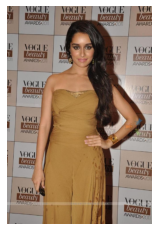

In [50]:
plt.imshow(img)
plt.axis('off')

ge = preds_gend.detach().cpu().numpy()
ag = preds_age.detach().cpu().numpy()

g = [gen_dict[ges] for ges in ge]
a = [age_dict[ags] for ags in ag]
e = [em_dict[es] for es in emotion]
print('Género: ', g[0])
print('Edad: ', a[0])
print('Emoción: ', e[0])
# Mujer:1, Hombre:0
# {0:'Angry',1:'Neutral',2:'Happy'}

In [13]:
path = 'Recognition/name/lfw_funneled'
text_files2 = glob.glob(path + "/**/*.jpg", recursive = True)

In [37]:
start_time = time.time()

#img = Image.open(path+str(r)+'.jpg')
r = np.random.randint(low=0, high=len(text_files))
img = Image.open(text_files2[r])

boxes, probs = mtcnn.detect(img)
faces = []
if boxes is not None:
    for i, (box, prob) in enumerate(zip(boxes, probs)):
        if prob>.85:
            face = extract_face(img, box, save_path="all/detected_face_{}.png".format(i))
            faces.append(face)

t = torch.stack(faces)/255

outputs = model_gend(t.to(device))
_, preds_gend = torch.max(outputs, 1)

outputs = model_age(t.to(device))
_, preds_age = torch.max(outputs, 1)

emotion = []

if t.shape[0]>1:
    for ts in t:
        t = transforms.ToPILImage()(ts)
        gray = transforms.Grayscale(num_output_channels=1)(t)
        #plt.imshow(gray, cmap='gray')
        gray = transforms.ToTensor()(np.array(gray).astype('float32')/255)
        outputs = model_em(gray.unsqueeze(0).to(device))
        _, preds_em = torch.max(outputs, 1)
        emotion.append(preds_em.detach().cpu().numpy()[0])
else:    
    t = transforms.ToPILImage()(t.squeeze(0))
    gray = transforms.Grayscale(num_output_channels=1)(t)
    #plt.imshow(gray, cmap='gray')
    gray = transforms.ToTensor()(np.array(gray).astype('float32')/255)
    outputs = model_em(gray.unsqueeze(0).to(device))
    _, preds_em = torch.max(outputs, 1)
    emotion.append(preds_em.detach().cpu().numpy()[0])
"""    
print('Género: ', preds_gend.detach().cpu())
print('Edad: ', preds_age.detach().cpu())
print('Emoción: ', emotion)"""
print('Time: ', time.time()-start_time)
print('Probabilities: ', probs)


Time:  0.13184070587158203
Probabilities:  [0.9998957]


Género:  Hombre
Edad:  16-30 años
Emoción:  Happy


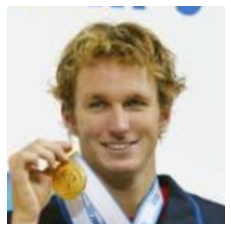

In [38]:
plt.imshow(img)
plt.axis('off')

ge = preds_gend.detach().cpu().numpy()
ag = preds_age.detach().cpu().numpy()

g = [gen_dict[ges] for ges in ge]
a = [age_dict[ags] for ags in ag]
e = [em_dict[es] for es in emotion]
print('Género: ', g[0])
print('Edad: ', a[0])
print('Emoción: ', e[0])
# Mujer:1, Hombre:0
# {0:'Angry',1:'Neutral',2:'Happy'}